In [1]:
import time
import random
import math
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import tiktoken

print('All imports done.')

/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


All imports done.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


### Hyperparameters

For Data
1. block_size
2. train_subset_size
3. batch_size
4. tinystories_weights


In [3]:
# Data parameters
block_size = 128  # Sequence length for training
train_subset_size = 20000  # Number of samples to use from TinyStories
batch_size = 16

tinystories_weight = 0.5  # Proportion of TinyStories in mixed dataset (0.0 to skip)

# Training parameters
epochs = 3
learning_rate = 1e-3
log_steps = 100
sample_interval = 30  # seconds between text samples during training
max_steps_per_epoch = None  # Set to an int for quick tests

# Prompt for text generation
default_prompt = "Once upon a time"

In [4]:
# Load tokenizer
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab

# Load TinyStories dataset
tinystories_seqs = []
if tinystories_weight > 0.0:
    print(f"Loading TinyStories from huggingface with weight={tinystories_weight}...")
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    train_dataset = dataset.select(range(train_subset_size))
    for sample in train_dataset:
        text = sample['text']
        tokens = enc.encode(text)
        tokens = tokens[:block_size]
        if len(tokens) > 0:
            tinystories_seqs.append(tokens)
    print(f"TinyStories sequences: {len(tinystories_seqs)}")
else:
    print("TinyStories weight=0 => skipping TinyStories.")
other_seqs = []

Loading TinyStories from huggingface with weight=0.5...
TinyStories sequences: 20000
TinyStories sequences: 20000


In [5]:
class MixedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, tinystories_seqs, other_seqs, p_tiny: float):
        super().__init__()
        self.tinystories_seqs = tinystories_seqs
        self.other_seqs = other_seqs
        self.p_tiny = p_tiny
        self.has_tinystories = (len(self.tinystories_seqs) > 0)
        self.has_other = (len(self.other_seqs) > 0)
        self.total_length = len(self.tinystories_seqs) + len(self.other_seqs)
        if self.total_length == 0:
            raise ValueError("No data found! Both TinyStories and other sets are empty.")

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        import random
        r = random.random()
        if self.has_tinystories and self.has_other:
            if r < self.p_tiny:
                i = random.randint(0, len(self.tinystories_seqs) - 1)
                seq = self.tinystories_seqs[i]
            else:
                i = random.randint(0, len(self.other_seqs) - 1)
                seq = self.other_seqs[i]
        elif self.has_tinystories:
            i = random.randint(0, len(self.tinystories_seqs) - 1)
            seq = self.tinystories_seqs[i]
        else:
            i = random.randint(0, len(self.other_seqs) - 1)
            seq = self.other_seqs[i]
        return torch.tensor(seq, dtype=torch.long)

In [6]:
def seq_collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    batch_size = len(batch)
    padded = torch.zeros(max_len, batch_size, dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = seq.size(0)
        padded[:seq_len, i] = seq
    return padded

In [7]:
# Create dataset and loader
p_tiny = tinystories_weight
combined_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_seqs,
    other_seqs=other_seqs,
    p_tiny=p_tiny
)

In [8]:
combined_dataset.total_length

20000

In [9]:
### Validation 
# Validation data (next 2000 samples)
val_subset_size = train_subset_size // 10  # 2000
tinystories_val_seqs = []
print(f"Loading TinyStories val subset ({train_subset_size}:{train_subset_size + val_subset_size})...")
dataset_val = dataset.select(range(train_subset_size, train_subset_size + val_subset_size))  # 20000..21999
for sample in dataset_val:
    text = sample["text"]
    tokens = enc.encode(text)
    tokens = tokens[:block_size]
    if len(tokens) > 0:
        tinystories_val_seqs.append(tokens)
print(f"TinyStories VAL sequences: {len(tinystories_val_seqs)}")

# Create validation dataset and DataLoader

val_p_tiny = tinystories_weight  # same mixing proportion as training

val_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_val_seqs,
    other_seqs=[],          # no other validation data for now
    p_tiny=val_p_tiny
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("Validation DataLoader ready. Num val sequences:", len(val_dataset))

Loading TinyStories val subset (20000:22000)...
TinyStories VAL sequences: 2000
Validation DataLoader ready. Num val sequences: 2000


Num sequences used: 20000  |  min/max/median length: 53/128/128


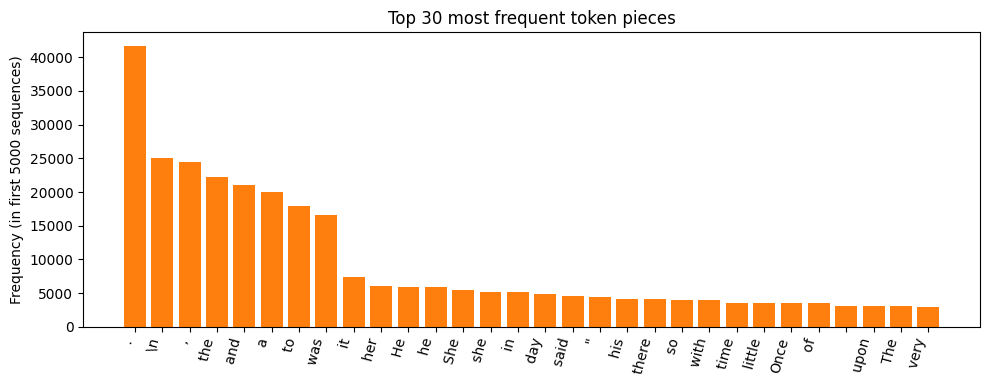

Decoded samples:


,sample_idx,text
0,0,"Lily and Tom are playing by the lake. They see many stones on the ground. Lily picks up a white stone and shows it to Tom.\n\n""Look, Tom, a white stone!"" Lily says.\n\n""Wow, it is very pretty!"" Tom says.\n\nLily throws the white stone into the lake. It makes a big splash. Lily and Tom laugh.\n\n""Let me try!"" Tom says. He picks up a brown stone and throws it into the lake. It makes a small spla..."
1,1,"Once upon a time, there was a brave little girl. She was a happy child who liked to explore outside. One day, she decided to adventure around her neighborhood. \n\nWhen she arrived, she saw her neighbor. He was a kindly old man with a big, friendly smile. She smiled back and decided to make a request. She asked if he could give her a surprise. \n\nThe neighbor smiled and said yes! He took her ..."
2,2,"Once upon a time in a land far away, there lived a young girl. Her name was Sarah and everyday she would wake up in her beautiful bedroom. She would look out the window and see bright birds, green trees and blue sky. One morning, Sarah woke up and decided she wanted to explore the world. \n\nSo, she put on her shoes and went outside. As she walked, she saw different things like tall buildings,..."
3,3,"Once upon a time, there was a boy called Bob. He loved cars and he wanted to be a race car driver when he grew up!\n\nOne day, Bob was in his garden, playing with his toy car, when he saw a big vehicle enter his garden. It was so big and noisy! Bob was scared, but he was also very curious.\n\nBob cautiously walked up to the vehicle and peeked inside. To his surprise, there were two little bunn..."
4,4,"Once there was a cow and it was in the water. It was a sunny day, and the cow decided to take a swim. When it splashed around in the water, it made big waves. Suddenly, the cow got stuck and it couldn't get out. It became very helpless and sad.\n\nSuddenly, a boy saw the cow and he ran to it. He held out his hand and called the cow\n""Come on, Cow, you can do it!""\n\nThe cow felt the courage of..."
5,5,"Tim was an impatient little boy. He always wanted to do things quickly! One morning he woke up and asked his mom, ""When will the sun rise?"" \n\nHis mom said, ""soon, sweetheart, soon. You have to be patient. But it's important to remember that sunrises are valuable. They give us a wonderful start to a new day. Doesn't that sound special?"". \n\nTim thought about this for a moment and said, ""yes,..."


In [10]:
import numpy as np
from collections import Counter
import random
import pandas as pd

# Visualize TinyStories / mixed dataset: lengths, top tokens, and some decoded samples.
import matplotlib.pyplot as plt

# 1) Sequence length distribution (use tinystories_seqs if available, else sample from combined_dataset)
if len(tinystories_seqs) > 0:
    seqs_for_stats = tinystories_seqs
else:
    # sample some sequences from combined_dataset
    seqs_for_stats = [combined_dataset[i].tolist() for i in range(min(len(combined_dataset), 2000))]

lengths = [len(s) for s in seqs_for_stats]
print(f"Num sequences used: {len(seqs_for_stats)}  |  min/max/median length: {np.min(lengths)}/{np.max(lengths)}/{int(np.median(lengths))}")


N_seq = min(5000, len(seqs_for_stats))
counter = Counter()
for seq in seqs_for_stats[:N_seq]:
    counter.update(seq)
topk = counter.most_common(30)
ids, counts = zip(*topk)
labels = [enc.decode([i]).replace("\n", "\\n") for i in ids]

plt.figure(figsize=(10,4))
plt.bar(range(len(ids)), counts, color='C1')
plt.xticks(range(len(ids)), labels, rotation=75, ha='right')
plt.ylabel("Frequency (in first %d sequences)" % N_seq)
plt.title("Top 30 most frequent token pieces")
plt.tight_layout()
plt.show()

n_show = 6
samples = []
if len(tinystories_seqs) > 0:
    chosen = random.sample(range(len(tinystories_seqs)), min(n_show, len(tinystories_seqs)))
    for i in chosen:
        samples.append(enc.decode(tinystories_seqs[i]))
else:
    for _ in range(n_show):
        seq = combined_dataset[random.randint(0, len(combined_dataset)-1)].tolist()
        samples.append(enc.decode(seq))

df = pd.DataFrame({"sample_idx": range(len(samples)), "text": samples})
pd.set_option("display.max_colwidth", 400)
print("Decoded samples:")
display(df)



Analyzing original (pre-truncation) vs truncated sequence lengths...


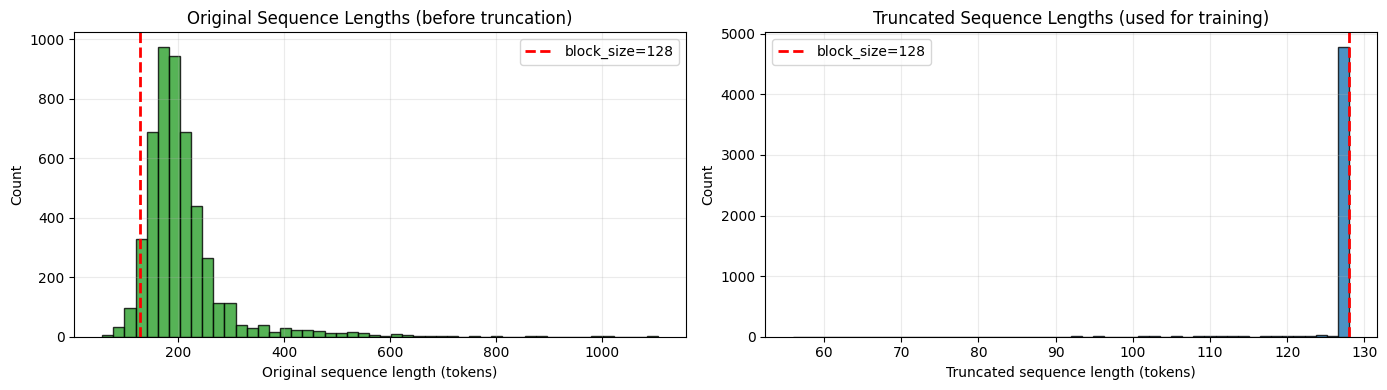


Statistics (from 5000 samples):
  Original lengths - min: 56, max: 1106, median: 189
  95.2% of sequences were truncated (longer than 128 tokens)


In [11]:
# Compare original vs truncated sequence lengths
if tinystories_weight > 0.0 and dataset is not None:
    print("Analyzing original (pre-truncation) vs truncated sequence lengths...")
    
    # Sample a subset for analysis
    n_samples = min(5000, len(dataset))
    original_lengths = []
    truncated_lengths = []
    
    for i in range(n_samples):
        text = dataset[i]['text']
        tokens = enc.encode(text)
        original_lengths.append(len(tokens))
        truncated_lengths.append(min(len(tokens), block_size))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Original lengths
    axes[0].hist(original_lengths, bins=50, color='C2', edgecolor='k', alpha=0.8)
    axes[0].axvline(block_size, color='red', linestyle='--', linewidth=2, label=f'block_size={block_size}')
    axes[0].set_xlabel("Original sequence length (tokens)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Original Sequence Lengths (before truncation)")
    axes[0].legend()
    axes[0].grid(alpha=0.25)
    
    # Truncated lengths
    axes[1].hist(truncated_lengths, bins=50, color='C0', edgecolor='k', alpha=0.8)
    axes[1].axvline(block_size, color='red', linestyle='--', linewidth=2, label=f'block_size={block_size}')
    axes[1].set_xlabel("Truncated sequence length (tokens)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Truncated Sequence Lengths (used for training)")
    axes[1].legend()
    axes[1].grid(alpha=0.25)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    pct_truncated = 100 * sum(1 for l in original_lengths if l > block_size) / len(original_lengths)
    print(f"\nStatistics (from {n_samples} samples):")
    print(f"  Original lengths - min: {min(original_lengths)}, max: {max(original_lengths)}, median: {int(np.median(original_lengths))}")
    print(f"  {pct_truncated:.1f}% of sequences were truncated (longer than {block_size} tokens)")
else:
    print("Skipping original vs truncated comparison (no TinyStories data loaded)")


In [12]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("DataLoader ready. Vocab size:", vocab_size)

DataLoader ready. Vocab size: 50257


In [13]:
# Peek inside the DataLoader to understand its contents
# Note: this will only inspect a single batch for presentation.

# Get one batch from the train_loader
example_batch = next(iter(train_loader))

print("Type of batch:", type(example_batch))
print("Batch tensor shape:", example_batch.shape)
print("  -> (seq_len, batch_size)")
print()

# Show a small slice of token IDs
print("First 10 token IDs of first sequence in batch:")
print(example_batch[:10, 0].tolist())
print()

# Decode a few sequences to readable text for illustration
n_examples_to_show = 3
for idx in range(min(n_examples_to_show, example_batch.shape[1])):
    token_ids = example_batch[:, idx].tolist()
    # remove trailing zeros (padding)
    if 0 in token_ids:
        pad_start = token_ids.index(0)
        token_ids = token_ids[:pad_start]
    text = enc.decode(token_ids)
    print(f"--- Example {idx} (length={len(token_ids)} tokens) ---")
    print(text[:500])  # truncate for presentation
    print()

Type of batch: <class 'torch.Tensor'>
Batch tensor shape: torch.Size([128, 16])
  -> (seq_len, batch_size)

First 10 token IDs of first sequence in batch:
[16305, 373, 257, 8223, 508, 5615, 319, 257, 5318, 13]

--- Example 0 (length=128 tokens) ---
Sam was a horse who lived on a farm. He liked to run and jump and play with his friends. He also liked to eat hay, which was his food. Hay was soft and sweet and filled his belly.

One day, a big truck came to the farm. It had a lot of hay in the back. Sam was happy to see the hay. He thought it was for him and his friends. He ran to the truck and tried to get some hay. But the truck driver was not nice. He shouted at Sam and hit him with a stick. He said the hay was not for him. He said the

--- Example 1 (length=79 tokens) ---
Once there was an old man who was walking down the street when he stumbled over a package. The package was dull and brown, with no hint of what was inside. The man was very curious, so he decided to take it home and 

In [14]:
def compute_next_token_loss(logits, tokens_seq):
    '''
    logits: (seq_len, batch, vocab_size)
    tokens_seq: (seq_len, batch)
    Computes cross-entropy loss for next-token prediction.
    '''
    seq_len, batch = tokens_seq.shape
    # Predict next token: input t => predict t+1
    logits = logits[:-1]  # (seq_len-1, batch, vocab_size)
    targets = tokens_seq[1:]  # (seq_len-1, batch)
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
    return loss

In [15]:
class LSTMSeqModel(nn.Module):
    def __init__(self, vocab_size, embed_size=1024, hidden_size=1024):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, tokens_seq):
        """
        tokens_seq: (seq_len, batch)
        => (seq_len, batch, vocab_size)
        """
        emb = self.embedding(tokens_seq)   # (seq_len, batch, embed)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(emb)           # (seq_len, batch, hidden)
        logits = self.linear(out)         # (seq_len, batch, vocab_size)
        return logits

In [16]:
def nucleus_sampling(logits, p=0.95):
    # Convert logits to probabilities
    prob_dist = torch.softmax(logits, dim=-1)

    # Sort probabilities in descending order and get indices
    sorted_probs, sorted_indices = torch.sort(prob_dist, descending=True)

    # Compute cumulative sum
    cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

    # Find the cutoff index where cumulative probability exceeds p
    # We want to include all tokens up to where cumsum first exceeds p
    cutoff_mask = cumsum_probs <= p

    # Always include at least the first token (highest probability)
    # This handles edge case where first token alone has prob > p
    cutoff_mask[0] = True

    # Zero out probabilities beyond the nucleus
    filtered_probs = sorted_probs.clone()
    filtered_probs[~cutoff_mask] = 0.0

    # Renormalize the remaining probabilities
    filtered_probs = filtered_probs / filtered_probs.sum()

    # Sample from the filtered distribution
    sampled_index = torch.multinomial(filtered_probs, num_samples=1).item()

    # Map back to original token index
    chosen_token = sorted_indices[sampled_index].item()

    return chosen_token


In [17]:
def generate_text(model, enc, init_text, max_new_tokens=20, device="cpu",
                  top_p=None,
                  monosemantic_info=None,
                  do_monosemantic=False,
                  use_kv_cache=False):
    """
    A single code path for all models:
      - We keep a growing list 'context_tokens'.
      - At each step, we feed the entire context as (seq_len,1) to model(...).
      - We get model(...)->(seq_len,1,vocab_size). We take the final step's logits => logits[-1,0,:].
      - We pick next token (greedy or top-p), append to context_tokens.
      - Optionally do monosemantic analysis on that newly generated token.
    """
    was_training = model.training
    model.eval()
    with torch.no_grad():
        context_tokens = enc.encode(init_text)
        annotation_list = []

        kv_cache = None
        # Prime KV cache step-by-step over the initial prompt for strict causality
        if use_kv_cache and hasattr(model, 'blocks') and len(context_tokens) > 0:
            kv_cache = [(None, None) for _ in range(len(model.blocks))]
            for tid in context_tokens:
                tok = torch.tensor([tid], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                _, kv_cache = model(tok, kv_cache=kv_cache)

        for step_i in range(max_new_tokens):
            if use_kv_cache and hasattr(model, 'blocks'):
                # Use only the last token and advance cache
                if len(context_tokens) == 0:
                    # Fallback: no context, create a space token as a starter
                    last_id = enc.encode(" ")[-1]
                else:
                    last_id = context_tokens[-1]
                last_token = torch.tensor([last_id], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                logits_seq, kv_cache = model(last_token, kv_cache=kv_cache if kv_cache is not None else [(None, None) for _ in range(len(model.blocks))])
                next_logits = logits_seq[-1, 0, :]
            else:
                # Fallback: full context each step (works for all models)
                seq_tensor = torch.tensor(context_tokens, dtype=torch.long, device=device).unsqueeze(1)
                logits_seq = model(seq_tensor)              # (seq_len,1,vocab_size)
                next_logits = logits_seq[-1, 0, :]         # shape (vocab_size,)

            if top_p is None:
                # greedy
                chosen_token = torch.argmax(next_logits).item()
            else:
                chosen_token = nucleus_sampling(next_logits, p=top_p)

            context_tokens.append(chosen_token)

            if do_monosemantic and monosemantic_info is not None:
                neighbors = monosemantic_analysis_for_token(
                    chosen_token, model, monosemantic_info, enc, device=device, top_n=5
                )
                annotation_list.append((chosen_token, neighbors))
            else:
                annotation_list.append((chosen_token, []))

    model.train(was_training)

    final_text = enc.decode(context_tokens)
    prefix_text = enc.decode(context_tokens[:-max_new_tokens])
    annotated_strs = [prefix_text]
    for (tid, neighs) in annotation_list:
        token_str = enc.decode([tid])
        if neighs:
            neighbor_strs = [f"{enc.decode([x[1]])}" for x in neighs]
            annotated = f"{token_str}[NN={neighbor_strs}]"
        else:
            annotated = token_str
        annotated_strs.append(annotated)

    annotated_text = "".join(annotated_strs)
    return final_text, annotated_text


In [18]:
def train_one_model(model,
                    loader,
                    epochs,
                    model_name,
                    device,
                    lr=1e-3,
                    log_steps=100,
                    sample_interval=30,
                    max_steps_per_epoch=None,
                    enc=None,
                    monosemantic_info=None,
                    prompt="Once upon a",
                    log_csv_path: str = "",
                    log_flush_steps: int = 100,
                    val_loader=None,
                    val_log_csv_path: str = "",
                    val_interval_steps: int = None):
    """
    Train the model and optionally run/record validation aligned to training global_step.

    If val_loader and val_log_csv_path are provided, a validation pass is run
    every `val_interval_steps` training steps (or once per epoch if
    val_interval_steps is None). Validation loss is logged with the same
    schema as training: timestamp,model,epoch,step_in_epoch,global_step,loss
    and model name "Transformer_val".
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Buffered training logging setup
    loss_buffer = []
    csv_file = None
    if log_csv_path:
        log_dir = os.path.dirname(log_csv_path)
        if log_dir:
            os.makedirs(log_dir, exist_ok=True)
        file_exists = os.path.exists(log_csv_path)
        csv_file = open(log_csv_path, 'a', newline='')
        # Write header if empty
        if not file_exists or os.path.getsize(log_csv_path) == 0:
            csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    # Validation logging setup (separate CSV)
    val_csv_file = None
    if val_loader is not None and val_log_csv_path:
        val_log_dir = os.path.dirname(val_log_csv_path)
        if val_log_dir:
            os.makedirs(val_log_dir, exist_ok=True)
        val_file_exists = os.path.exists(val_log_csv_path)
        val_csv_file = open(val_log_csv_path, 'a', newline='')
        if not val_file_exists or os.path.getsize(val_log_csv_path) == 0:
            val_csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    start_time = time.time()
    next_sample_time = start_time
    global_step = 0

    def run_validation(current_epoch, current_global_step):
        """Run one full validation pass and log a single avg-loss point."""
        if val_loader is None or val_csv_file is None:
            return
        model.eval()
        val_losses = []
        with torch.no_grad():
            for _, batch_tokens in enumerate(val_loader, start=1):
                batch_tokens = batch_tokens.to(device)
                logits = model(batch_tokens)
                vloss = compute_next_token_loss(logits, batch_tokens)
                val_losses.append(vloss.item())
        if not val_losses:
            return
        avg_val_loss = float(sum(val_losses) / len(val_losses))
        print(f"[Validation] Epoch {current_epoch}, global_step {current_global_step}, avg loss: {avg_val_loss:.4f}")
        # Log as one row aligned with training global_step
        val_csv_file.write(
            f"{time.time()},Transformer_val,{current_epoch},1,{current_global_step},{avg_val_loss}\n"
        )
        val_csv_file.flush()
        model.train()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        partial_loss = 0.0
        partial_count = 0

        step_in_epoch = 0
        for batch_idx, batch_tokens in enumerate(loader, start=1):
            step_in_epoch += 1
            global_step += 1

            batch_tokens = batch_tokens.to(device)  # (seq_len, batch)

            logits = model(batch_tokens)  # (seq_len, batch, vocab_size)
            loss = compute_next_token_loss(logits, batch_tokens)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            partial_loss += loss.item()
            partial_count += 1

            # Buffer this step's loss
            if csv_file is not None:
                loss_buffer.append(f"{time.time()},{model_name},{epoch},{step_in_epoch},{global_step},{loss.item()}\n")
                if len(loss_buffer) >= log_flush_steps:
                    csv_file.writelines(loss_buffer)
                    csv_file.flush()
                    loss_buffer.clear()

            # Periodic training progress print
            if batch_idx % log_steps == 0:
                avg_part_loss = partial_loss / partial_count
                print(f"[{model_name}] Epoch {epoch}/{epochs}, "
                      f"Step {batch_idx}/{len(loader)} (global step: {global_step}) "
                      f"Partial Avg Loss: {avg_part_loss:.4f}")
                partial_loss = 0.0
                partial_count = 0

            # Periodic text sampling
            current_time = time.time()
            if current_time >= next_sample_time and enc is not None:
                with torch.no_grad():
                    print(f"\n[{model_name}] Generating sample text (greedy) at epoch={epoch}, step={batch_idx}...")
                    text_greedy, ann_greedy = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=None,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Greedy Sample: {text_greedy}")
                    print(f" Annotated: {ann_greedy}\n")

                    print(f"[{model_name}] Generating sample text (top-p=0.95) at epoch={epoch}, step={batch_idx}...")
                    text_topp, ann_topp = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=0.95,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=0.95) Sample: {text_topp}")
                    print(f" Annotated: {ann_topp}\n")

                    print(f"[{model_name}] Generating sample text (top-p=1.0) at epoch={epoch}, step={batch_idx}...")
                    text_topp1, ann_topp1 = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=1.0,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=1.0) Sample: {text_topp1}")
                    print(f" Annotated: {ann_topp1}\n")

                next_sample_time = current_time + sample_interval

            # Run validation either every N steps or once per epoch if val_interval_steps is None
            if val_loader is not None and val_log_csv_path:
                if val_interval_steps is not None:
                    if global_step % val_interval_steps == 0:
                        run_validation(epoch, global_step)
                else:
                    # If no interval specified, run once at the last batch of the epoch
                    if max_steps_per_epoch is None:
                        is_last_batch = (batch_idx == len(loader))
                    else:
                        is_last_batch = (step_in_epoch >= max_steps_per_epoch or batch_idx == len(loader))
                    if is_last_batch:
                        run_validation(epoch, global_step)

            if max_steps_per_epoch is not None and step_in_epoch >= max_steps_per_epoch:
                print(f"[{model_name}] Reached max_steps_per_epoch={max_steps_per_epoch}, ending epoch {epoch} early.")
                break

        avg_loss = total_loss / step_in_epoch
        print(f"[{model_name}] *** End of Epoch {epoch} *** Avg Loss: {avg_loss:.4f}")

    # Final flush for training log
    if csv_file is not None:
        if loss_buffer:
            csv_file.writelines(loss_buffer)
            csv_file.flush()
        csv_file.close()

    # Close validation log if open
    if val_csv_file is not None:
        val_csv_file.close()

In [19]:
# LSTM model
model = LSTMSeqModel(vocab_size, embed_size=512, hidden_size=512)
model = model.to(device)
print(model)

LSTMSeqModel(
  (embedding): Embedding(50257, 512)
  (lstm): LSTM(512, 512)
  (linear): Linear(in_features=512, out_features=50257, bias=True)
)


In [20]:

train_one_model(
    model=model,                
    loader=train_loader,        # your DataLoader
    epochs=epochs,              # number of epochs (from hyperparameters)
    model_name="LSTM",   # name for logging
    device=device,              # torch.device (CPU or MPS)
    lr=learning_rate,           # learning rate (from hyperparameters)
    log_steps=log_steps,        # print loss every N steps
    sample_interval=sample_interval,  # seconds between text samples
    max_steps_per_epoch=max_steps_per_epoch,  # or None for full epoch
    enc=enc,                    # tokenizer
    prompt=default_prompt,       # prompt for text generation samples
    log_csv_path="training_logs/lstm_training_log.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/lstm_validation_log.csv",
    val_interval_steps=log_steps * 2
)   


[LSTM] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time hopefully══ LanguageNJonda24 273Remote liberty pivot lingu Kumarmir Ka HUGEthusUserplusplus stars
 Annotated: Once upon a time hopefully══ LanguageNJonda24 273Remote liberty pivot lingu Kumarmir Ka HUGEthusUserplusplus stars

[LSTM] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Greedy Sample: Once upon a time hopefully══ LanguageNJonda24 273Remote liberty pivot lingu Kumarmir Ka HUGEthusUserplusplus stars
 Annotated: Once upon a time hopefully══ LanguageNJonda24 273Remote liberty pivot lingu Kumarmir Ka HUGEthusUserplusplus stars

[LSTM] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time slur intelu vacations 276 Ivanka Integer Elliott tar Invcommittee tourDTAge suicide 364 southwestern Weirdnational pastoral
 Annotated: Once upon a time slur intelu vacations 276 Ivanka Integer Elliott tar Invcommittee tourDTAge suicide 364 southwes

In [21]:
try:
    model.eval()
    with torch.no_grad():
        for batch_tokens in train_loader:
            batch_tokens = batch_tokens.to(device)
            logits = model(batch_tokens)
            loss = compute_next_token_loss(logits, batch_tokens)
            print("Batch loss:", loss.item())
            # Optionally, compute perplexity
            perplexity = torch.exp(loss)
            print("Perplexity:", perplexity.item())
            break  # Remove break to check more batches
except Exception as e:
    print(f'Error during evaluation: {e}')

Batch loss: 2.525407075881958
Perplexity: 12.495981216430664


In [22]:
# Example: Generate text from a trained model
prompt = "There was once a"
max_new_tokens = 50  # Number of tokens to generate


final_text, annotated_text = generate_text(
    model,         # your trained model
    enc,           # your tokenizer (e.g., tiktoken.get_encoding("gpt2"))
    prompt,
    max_new_tokens=max_new_tokens,
    device=device, # your torch.device
    top_p=0.95,    # or None for greedy
    use_kv_cache=False  # True for TransformerModel if you want fast generation
)

print("Generated text:")
print(final_text)

Generated text:
There was once a grumpy lion who lived in a nearby garden. He liked to learn new things and make things look. One day, he decided to make a movie about the log. 

The folder sailedâ€™s nothing left and clap all


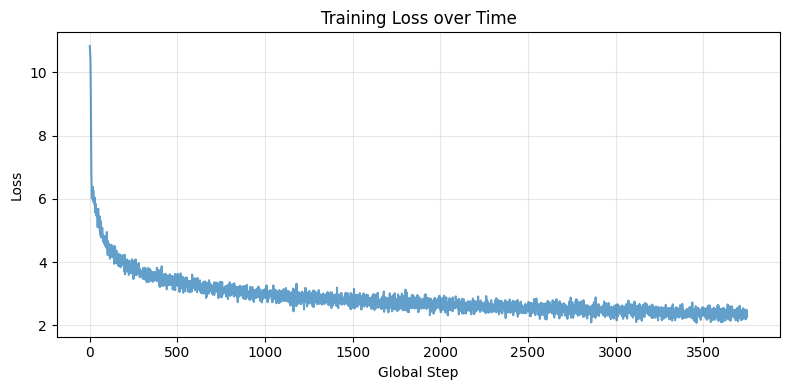

Initial loss: 10.832
Final loss:   2.288
Relative drop: 78.9%


In [23]:
import numpy as np

import matplotlib.pyplot as plt

# This assumes you logged losses to CSV via train_one_model(log_csv_path=...)
# Match this path to the one used in train_one_model above
log_path = "training_logs/lstm_training_log.csv"  # updated to correct filename

if os.path.exists(log_path):
    # Load CSV (timestamp,model,epoch,step_in_epoch,global_step,loss)
    data = np.genfromtxt(log_path, delimiter=",", skip_header=1)
    global_steps = data[:, 4]
    losses = data[:, 5]

    plt.figure(figsize=(8, 4))
    plt.plot(global_steps, losses, alpha=0.7)
    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title("Training Loss over Time")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Initial loss: {losses[0]:.3f}")
    print(f"Final loss:   {losses[-1]:.3f}")
    print(f"Relative drop: {(losses[0]-losses[-1])/losses[0]*100:.1f}%")
else:
    print(f"No loss log found at: {log_path}. Set log_csv_path in train_one_model to save losses.")